In this notebook, we test the GCN with different loss metrics to see which yields the most desirable performance.

### imports and setup

In [1]:
# # google colab setup (comment out this cell if running locally)
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd "/content/drive/My Drive/_research ML AQ/lorenz 96 gnn" # so we can access pre-generated lorenz data
# !pip3 install spektral

In [2]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

In [3]:
# import packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from spektral.data import MixedLoader
from datetime import datetime

from lorenz import lorenzDataset, DEFAULT_TIME_RESOLUTION
from plotters import plot_data
from tuning import make_train_GCN, plot_model_results, tune_params
from models import NaiveConstant, NaiveZero

2023-02-07 09:59:21.109267: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# check that GPU is set up
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('no GPU device found')
else:
  print('found GPU at: {}'.format(device_name))
print('num GPUs available:', len(tf.config.list_physical_devices("GPU")))

no GPU device found
num GPUs available: 0


2023-02-07 09:59:28.249333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### prepare data

In [5]:
# only uncomment each line if testing a non-default parameter
dataset = lorenzDataset(
    n_samples=100_000,
    # input_steps=2 * DEFAULT_TIME_RESOLUTION,  # 2 days
    # output_delay=1 * DEFAULT_TIME_RESOLUTION,  # 1 day
    # output_steps=1,
    min_buffer=-3 * DEFAULT_TIME_RESOLUTION,
    # rand_buffer=False,
    # K=36,
    # F=8,
    # c=10,
    # b=10,
    # h=1,
    # coupled=True,
    # time_resolution=DEFAULT_TIME_RESOLUTION,
    # seed=42
)

reading Lorenz data from stored file


In [6]:
train = dataset[:int(0.7 * dataset.n_graphs)]
val = dataset[int(0.7 * dataset.n_graphs):int(0.9 * dataset.n_graphs)]
test = dataset[int(0.9 * dataset.n_graphs):]


In [7]:
train_loader = MixedLoader(dataset=train, batch_size=32, shuffle=False)
val_loader = MixedLoader(dataset=val, batch_size=32, shuffle=False)


In [8]:
# TODO: store normalized train/val/test data

# normalize data
start = datetime.now()
X1_mean, X1_std, X2_mean, X2_std = train.get_mean_std()
finish_get_means = datetime.now()
print('time to get means:', finish_get_means - start)

train.normalize(X1_mean, X1_std, X2_mean, X2_std)
val.normalize(X1_mean, X1_std, X2_mean, X2_std)
test.normalize(X1_mean, X1_std, X2_mean, X2_std)
finish_normalize = datetime.now()

print('time to normalize data:', finish_normalize - finish_get_means)

time to concat: 0:00:30.386493
time to get std&mean from X1: 0:01:36.155887
time to get std&mean from X2: 0:00:44.706529
time to get means: 0:02:52.017945
time to normalize data: 0:01:14.489350


inspect data
(commented out because it takes too long to plot so many data points and I'm confident I know what it looks like)

In [9]:
# fig, (ax0, ax1) = plot_data(train, val, test, node=0)

# plt.tight_layout()
# plt.show()

## compare learning rates

I wanted to implement some helper functions to streamline hyperparameter tuning from the start. However, the existing libraries I've found for tuning in tensorflow require you to define models as a subclass of hypermodels, which is kind of a pain when I'm just using a GCN out of the box. For now I'm just gonna do the stupid way of running for-loops, maybe with dictionaries of parameters to make things a little nicer. (the helper function is in tuning.py.)

In [10]:
# TODO: fix this error, somewhere we are passing in a dictionary as a string where it is invalid

# param_dict = {'learning_rate': [1e-2, 1e-3, 1e-4, 1e-5]}

# results = tune_params(train,
#                 val,
#                 param_dict=param_dict,
#                 epochs=40,
#                 verbose=0,
#                 early_stopping=False,
#                 eval_val=True)

blegh deal with that error later and do some stupid simple stuff for now

In [11]:
LRs = [1e-2, 1e-3, 1e-4, 1e-5]

models = []
histories = []

for lr in LRs:
    print('running with learning rate', lr)
    model, history, fname = make_train_GCN(train, val, loss='mean_squared_error', activation="relu", epochs=20, eval_val=True, early_stopping=False, verbose=0)

    models.append(model)
    histories.append(history)

running with learning rate 0.01
running with learning rate 0.001
running with learning rate 0.0001
running with learning rate 1e-05


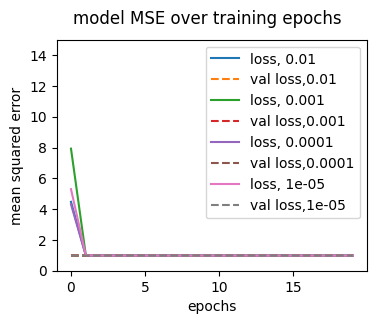

In [12]:
fig_train_loss, ax = plt.subplots(1, 1, figsize=(4, 3))

for i, lr in enumerate(LRs):
    model = models[i]
    history = histories[i]

    ax.plot(history.history['loss'], label='loss, ' + str(lr))
    if 'val_loss' in history.history:
        ax.plot(history.history['val_loss'], '--', label='val loss,' + str(lr))
ax.set_ylabel('mean squared error')
ax.set_xlabel('epochs')
fig_train_loss.suptitle('model MSE over training epochs')
ax.set_ylim((0, 15))
ax.legend()
plt.show()